In [1]:
import itertools
import functools

import numpy as np
import pandas as pd

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

from tqdm import tqdm

import sdnist

## 1. Load both the public & the private dataset

In [2]:
public, public_schema = sdnist.census(public=True)
private, private_schema = sdnist.census(public=False)
public

,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
0,17-1001,2012,88.0,1,61.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,118,902,909,12
1,17-1001,2012,61.0,1,85.0,1,21,6,1,0,...,3,18000,0,0,0,18000,262,732,744,33
2,17-1001,2012,54.0,1,54.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,118,642,654,401
3,17-1001,2012,106.0,1,69.0,1,21,6,1,0,...,3,3800,3800,0,0,3800,262,0,0,470
4,17-1001,2012,31.0,1,56.0,1,21,6,1,0,...,3,14000,14000,0,0,14000,501,0,0,702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035196,39-4300,2018,103.0,1,90.0,2,37,1,9,0,...,3,36000,36000,0,0,36000,231,1605,1624,556291
1035197,39-4106,2018,207.0,1,207.0,2,41,6,9,0,...,3,52800,52000,0,0,52000,361,1005,1019,1139708
1035198,17-2200,2018,73.0,1,58.0,2,46,4,9,0,...,2,25800,0,0,0,0,200,0,0,346052
1035199,17-2300,2018,47.0,1,47.0,2,46,1,9,0,...,3,5000,5000,0,0,5000,399,732,754,40265


In [3]:
BINS = sdnist.kmarginal.CensusKMarginalScore.BINS

public_bin = sdnist.utils.discretize(public, public_schema, BINS)
private_bin = sdnist.utils.discretize(private, private_schema, BINS)

## 2. First order bayesian network ($k=1$)

As described in *PrivBayes: Private Data Release via Bayesian Networks* (http://dimacs.rutgers.edu/~graham/pubs/papers/PrivBayes.pdf), except that we compute the tree structure on a public dataset.


### 2.1 Building the Chow-Liu tree structure from the public dataset

We represent the joint distribution as a first order bayesian network. The dependency tree is constructed from the public dataset.

In [4]:
COLS = list(public_schema.keys())
n = len(public_bin)

def mutual_information(df, col_a, col_b):
    ab = df.groupby([*col_a, col_b]).size().unstack(col_b, fill_value=0).to_numpy() / n
    a = ab.sum(axis=0, keepdims=True)
    b = ab.sum(axis=1, keepdims=True)
    
    llr = np.zeros_like(ab)
    np.log(ab / (a * b), where=ab > 0, out=llr)
    return np.sum(ab * llr)

def greedy_bayes(df, root: str = "PUMA", order=1):
    # Graph : for vizualization purposes
    graph = nx.DiGraph()
    graph.add_node(root)
    
    # Conditional distribution in topological order
    cond = [(root,)]

    # Greedy algorithm
    remaining = set(COLS)
    remaining.remove(root)
    
    mutual_information_memoize = functools.cache(functools.partial(mutual_information, df))
    
    for i in tqdm(range(len(COLS)-1)):
        max_col = None
        max_parents = None
        max_mi = 0
        
        for col in remaining:
            for parents in itertools.combinations(graph.nodes, r=min(len(graph.nodes), order)):
                mi = mutual_information_memoize(parents, col)
                
                if mi > max_mi:
                    max_mi = mi
                    max_col = col
                    max_parents = parents
                
        graph.add_node(max_col)
        graph.add_edges_from(((p, max_col) for p in max_parents), weight=max_mi)
        
        cond.append((*max_parents, max_col))
        
        remaining.remove(max_col)        
        
    return graph, cond
    
graph, cond = greedy_bayes(public, order=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.78it/s]


Text(0.5, 1.0, 'First order bayesian network over the public dataset')

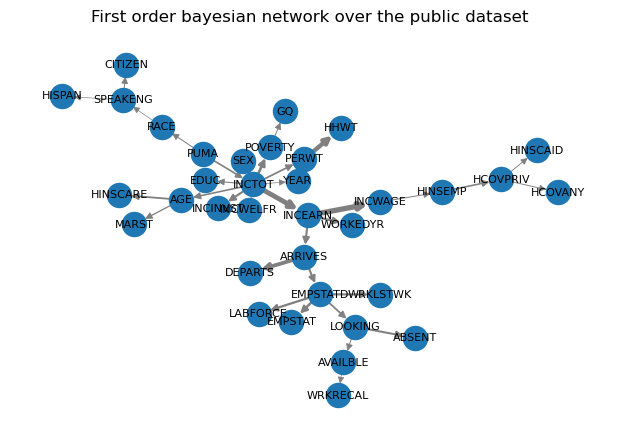

In [5]:
plt.figure(dpi=100)
pos = graphviz_layout(graph, prog="neato")
width = [w ** .5 * 2 for w in nx.get_edge_attributes(graph, "weight").values()]
nx.draw(graph, pos=pos, with_labels=True, font_size=8, width=width, edge_color="grey")
plt.title("First order bayesian network over the public dataset")

### 2.2 Computing the conditional distributions from the private dataset

We compute the conditional distribution on the private dataset using noisy histograms, for each edge of the tree and starting from the root column (PUMA).

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 29.55it/s]


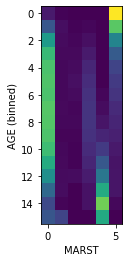

In [6]:
eps = 1
noise_scale = len(COLS) / (n * eps) * 7  # 7 accounts for repeated rows

def compute_marginal_distribution(df, column, noise_scale: float = 0):
    marginal = df.groupby(column).size() / n
    # Only place where the data is accessed
    if noise_scale > 0:
        marginal += np.random.laplace(scale=noise_scale, size=marginal.size)
        marginal = marginal.clip(lower=0)
    return marginal / marginal.sum(axis=0)

def compute_conditional_distribution(df, column, parents, noise_scale: float = 0):
    joint = (df.groupby([column] + parents).size() / n)
    joint = joint.unstack(column, fill_value=0)

    # Only place where the data is accessed
    if noise_scale > 0:
        joint += np.random.laplace(scale=noise_scale, size=joint.shape)
        joint = joint.clip(lower=0)
        
    return joint.div(joint.sum(axis=1), axis="rows")

def compute_bayesnet(df, cond, noise_scale: float = noise_scale):
    bayesnet = {}
    
    node = cond[0]
    *parents, root = node
    
    bayesnet[node] = compute_marginal_distribution(df, root, noise_scale)
    
    
    for node in tqdm(cond[1:]):
        *parents, column = node
        bayesnet[node] = compute_conditional_distribution(df, column, parents, noise_scale)
        
    return bayesnet
        
bayesnet = compute_bayesnet(private_bin, cond, noise_scale=noise_scale)

# Example: marital status as a function of the age
plt.imshow(bayesnet[("AGE", "MARST")].to_numpy())
plt.xlabel("MARST")
plt.ylabel("AGE (binned)")
plt.show()

For instance, we plotted the marital status distribution as a function of the age.

### 2.3 Generating sample from the estimated joint probability distribution

In [7]:
def generate_sample(columns, cond, bayesnet, size=10):
    synthetic = pd.DataFrame(0, columns=columns, index=np.arange(size))
    
    # Sample the first column as i.i.d variables on the root node.
    node = cond[0]
    *parents, root = node
    dist = bayesnet[node]
    synthetic[root] = dist.index[np.random.choice(a=len(dist), size=size, replace=True, p=dist.to_numpy())]
    
    # Conditional distributions
    for node in tqdm(cond[1:]):
        *parents, column = node
        dist = bayesnet[node]

        if len(parents) == 1:
            cumsum = dist.loc[synthetic[parents[0]]].to_numpy().cumsum(axis=1)
        else:
            raise NotImplementedError
            
        u = np.random.rand(size)
        k = (u[:, None] > cumsum).sum(axis=1)
        synthetic[column] = dist.columns[k]
        
    return synthetic

synthetic_bin = generate_sample(public_bin.columns, cond, bayesnet, size=len(private))

# Display the synthetic dataset
synthetic_bin

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.39it/s]


,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
0,64,0,8,1,11,0,9,0,5,4,...,3,19,19,1,1,19,26,18,89,0
1,150,0,15,1,26,1,13,4,0,0,...,3,5,1,1,1,5,6,45,54,0
2,175,2,8,1,9,0,8,3,8,0,...,3,8,4,1,1,8,17,41,41,0
3,21,0,7,1,14,1,11,4,0,0,...,3,5,5,1,1,5,16,30,31,0
4,114,3,2,1,2,0,10,0,3,4,...,3,6,1,1,1,1,14,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348359,116,1,9,1,6,0,7,5,0,0,...,3,5,5,1,1,5,7,17,19,0
1348360,29,0,3,1,3,0,8,0,0,0,...,3,8,8,1,1,8,18,29,33,0
1348361,54,4,3,1,3,1,5,0,0,0,...,3,9,9,1,1,9,26,56,75,0
1348362,164,0,5,1,5,0,2,5,0,0,...,1,3,1,1,1,1,6,1,1,0


### 2.4 Compute the final score

In [8]:
# Unbin data
synthetic = sdnist.utils.undo_discretize(synthetic_bin, private_schema, BINS)
synthetic

,PUMA,YEAR,HHWT,GQ,PERWT,SEX,AGE,MARST,RACE,HISPAN,...,WORKEDYR,INCTOT,INCWAGE,INCWELFR,INCINVST,INCEARN,POVERTY,DEPARTS,ARRIVES,sim_individual_id
0,36-3304,2012,140.0,1,200.0,1,60.0,1,6,4,...,3,90000.0,90000.0,0.0,0.0,90000.0,500.0,415.0,2200.0,0
1,42-1300,2012,280.0,1,500.0,2,80.0,5,1,0,...,3,20000.0,0.0,0.0,0.0,20000.0,100.0,1100.0,1315.0,0
2,42-2500,2014,140.0,1,160.0,1,55.0,4,9,0,...,3,35000.0,15000.0,0.0,0.0,35000.0,320.0,1000.0,1000.0,0
3,36-2002,2012,120.0,1,260.0,2,70.0,5,1,0,...,3,20000.0,20000.0,0.0,0.0,20000.0,300.0,715.0,730.0,0
4,36-4017,2015,20.0,1,20.0,1,65.0,1,4,4,...,3,25000.0,0.0,0.0,0.0,0.0,260.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348359,36-402,2013,160.0,1,100.0,1,50.0,6,1,0,...,3,20000.0,20000.0,0.0,0.0,20000.0,120.0,400.0,430.0,0
1348360,36-2500,2012,40.0,1,40.0,1,55.0,1,1,0,...,3,35000.0,35000.0,0.0,0.0,35000.0,340.0,700.0,800.0,0
1348361,36-3206,2016,40.0,1,40.0,2,40.0,1,1,0,...,3,40000.0,40000.0,0.0,0.0,40000.0,500.0,1345.0,1830.0,0
1348362,42-1900,2012,80.0,1,80.0,1,25.0,6,1,0,...,1,10000.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]


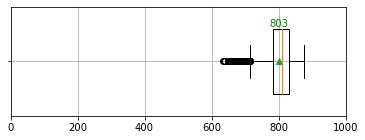

In [9]:
# Compute score
score = sdnist.score(private, synthetic, schema=private_schema, challenge="census")

plt.figure(figsize=(6, 2))
score.boxplot()